In [8]:
# Importação das bibliotecas necessárias para este projeto

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox


In [9]:
# Carregamento e preparação dos dados

def load_processed_data(path):
    df = pd.read_csv(path, parse_dates=['DATA'])
    df.set_index('DATA', inplace=True)
    return df

def agg_monthly_sales(df):
    monthly_df = df.groupby('DATA').agg({'QT_VENDA_BRUTO': 'sum'}).reset_index()
    monthly_df.set_index('DATA', inplace=True)
    return monthly_df

In [10]:
# Filtragem, agrupamento por data e ajuste de frequência mensal para o segmento

def prepare_segment_data(df, column_segment, segment):
    df_segment = df[df[column_segment] == segment].copy()
    df_segment = df_segment.groupby('DATA')[['QT_VENDA_BRUTO', 'FLG_DATA']].sum()
    df_segment = df_segment.asfreq('MS')
    return df_segment


In [11]:
# Testes estatísticos

def test_stationarity(serie):
    print("\n--- Testes de Estacionariedade ---")
    adf_stat, adf_p, _, _, _, _ = adfuller(serie)
    print(f"ADF: Estat={adf_stat:.4f}, p={adf_p:.4f} → {'Estacionária' if adf_p < 0.05 else 'Não estacionária'}")

    kpss_stat, kpss_p, _, _ = kpss(serie, regression='c', nlags='auto')
    print(f"KPSS: Estat={kpss_stat:.4f}, p={kpss_p:.4f} → {'Não estacionária' if kpss_p < 0.05 else 'Estacionária'}")

In [12]:
# Modelagem SARIMAX e métricas de avaliação

def adjust_sarimax_model(y, exog, order, seasonal_order):
    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order,
                     enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    return result

def generate_forecast(model, exog_future, steps=3):
    return model.forecast(steps=steps, exog=exog_future)

def evaluate_forecast(y_true, y_pred, y_train):
    mae = mean_absolute_error(y_true, y_pred)
    naive_forecast = y_train.shift(1).dropna()
    mase = mae / mean_absolute_error(y_train[1:], naive_forecast)
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))
    bias = np.mean(y_pred - y_true)

    print("\n--- Métricas de Avaliação ---")
    print(f"MAE:  {mae:.2f}")
    print(f"MASE: {mase:.3f}")
    print(f"wAPE: {wape * 100:.2f}%")
    print(f"Bias: {bias:.2f}")
    return mae, mase, wape, bias

def residuals_diagnosis(model):
    residuals = model.resid.dropna()
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(residuals)
    plt.title("Resíduos")

    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.title("Distribuição dos Resíduos")
    plt.tight_layout()
    plt.show()

    stat, p_shapiro = shapiro(residuals)
    print(f"Shapiro-Wilk: p={p_shapiro:.4f} → {'Normal' if p_shapiro > 0.05 else 'Não normal'}")

    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("\nLjung-Box (autocorrelação dos resíduos):")
    print(lb_test)

In [13]:
# Execução por segmento

def run_modeling_by_segment(df, column_segment, order, seasonal_order):
    segments = df[column_segment].unique()
    for s in segments:
        print(f"\n=== Segmento: {column_segment} = {s} ===")
        df_s = prepare_segment_data(df, column_segment, s)
        y = df_s['QT_VENDA_BRUTO']
        exog = df_s[['FLG_DATA']]
        y_train, y_test = y[:-3], y[-3:]
        exog_train, exog_test = exog[:-3], exog[-3:]

        test_stationarity(y_train)
        model = adjust_sarimax_model(y_train, exog_train, order, seasonal_order)
        forecast = generate_forecast(model, exog_test, steps=3)
        evaluate_forecast(y_test, forecast, y_train)
        residuals_diagnosis(model)


=== Segmento: COD_CANAL = anon_S0 ===

--- Testes de Estacionariedade ---
ADF: Estat=-3.5621, p=0.0065 → Estacionária
KPSS: Estat=0.2141, p=0.1000 → Estacionária


/var/folders/b7/j11xhgds7xj08061x1c3q5gm0000gn/T/ipykernel_8752/3981445790.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(serie, regression='c', nlags='auto')



--- Métricas de Avaliação ---
MAE:  11750913.25
MASE: 2.395
wAPE: 47.08%
Bias: -11750913.25


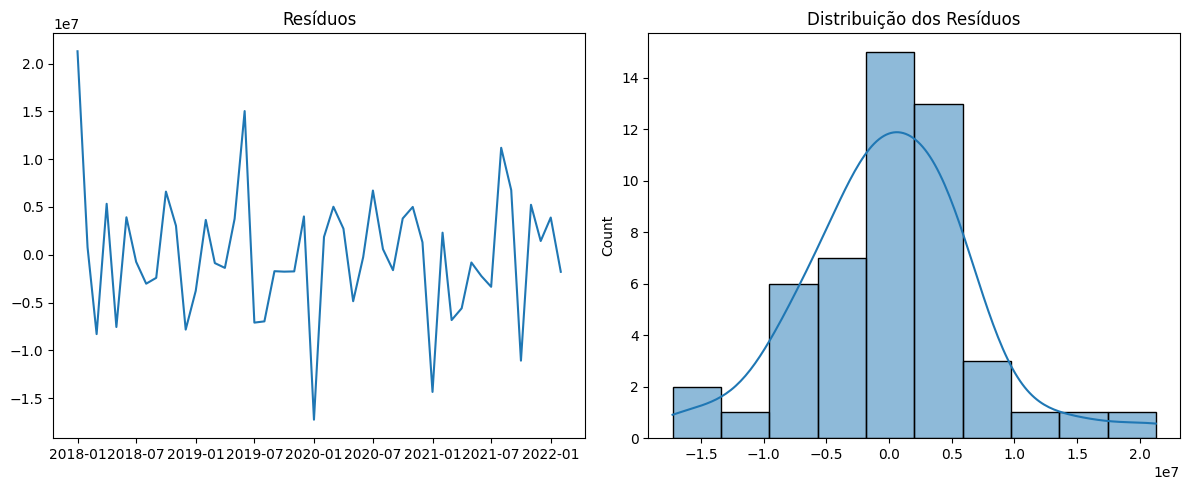

Shapiro-Wilk: p=0.1613 → Normal

Ljung-Box (autocorrelação dos resíduos):
     lb_stat  lb_pvalue
10  7.018058   0.723739

=== Segmento: COD_CANAL = anon_S7 ===

--- Testes de Estacionariedade ---
ADF: Estat=-5.6578, p=0.0000 → Estacionária
KPSS: Estat=0.3810, p=0.0853 → Estacionária

--- Métricas de Avaliação ---
MAE:  15219808.81
MASE: 2.730
wAPE: 52.12%
Bias: -15219808.81


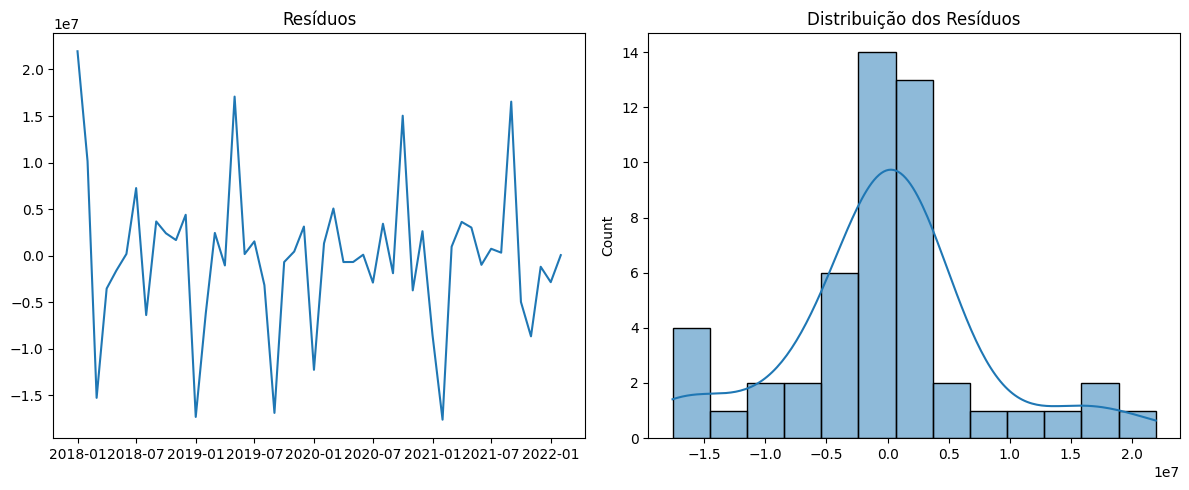

Shapiro-Wilk: p=0.0046 → Não normal

Ljung-Box (autocorrelação dos resíduos):
      lb_stat  lb_pvalue
10  11.275707   0.336445

=== Segmento: DES_CATEGORIA_MATERIAL = anon_S5 ===

--- Testes de Estacionariedade ---
ADF: Estat=-4.4828, p=0.0002 → Estacionária
KPSS: Estat=0.0800, p=0.1000 → Estacionária


/var/folders/b7/j11xhgds7xj08061x1c3q5gm0000gn/T/ipykernel_8752/3981445790.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(serie, regression='c', nlags='auto')



--- Métricas de Avaliação ---
MAE:  3338249.63
MASE: 1.936
wAPE: 39.84%
Bias: -3338249.63


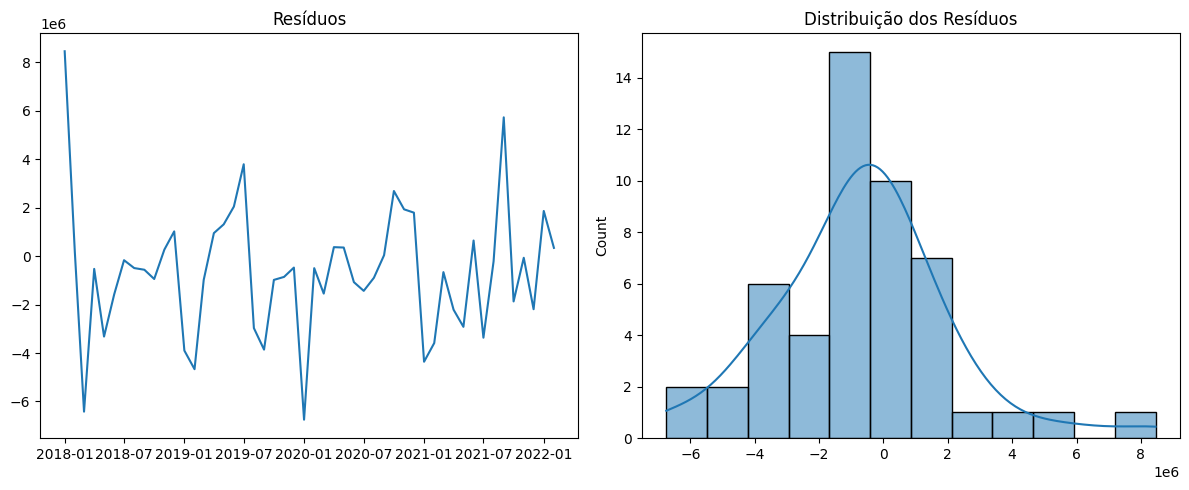

Shapiro-Wilk: p=0.0506 → Normal

Ljung-Box (autocorrelação dos resíduos):
     lb_stat  lb_pvalue
10  6.695969   0.753802

=== Segmento: DES_CATEGORIA_MATERIAL = anon_S12 ===

--- Testes de Estacionariedade ---
ADF: Estat=-4.4173, p=0.0003 → Estacionária
KPSS: Estat=0.0672, p=0.1000 → Estacionária


/var/folders/b7/j11xhgds7xj08061x1c3q5gm0000gn/T/ipykernel_8752/3981445790.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(serie, regression='c', nlags='auto')



--- Métricas de Avaliação ---
MAE:  13821161.71
MASE: 3.389
wAPE: 53.43%
Bias: -13821161.71


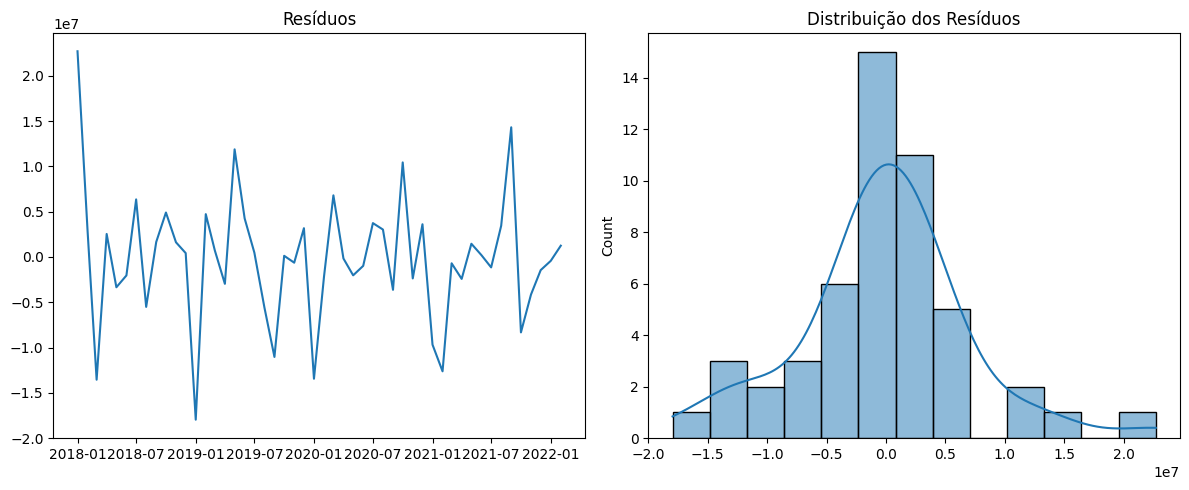

Shapiro-Wilk: p=0.0297 → Não normal

Ljung-Box (autocorrelação dos resíduos):
     lb_stat  lb_pvalue
10  8.585311   0.571858

=== Segmento: DES_CATEGORIA_MATERIAL = anon_S2 ===

--- Testes de Estacionariedade ---
ADF: Estat=-5.0294, p=0.0000 → Estacionária
KPSS: Estat=0.0859, p=0.1000 → Estacionária


/var/folders/b7/j11xhgds7xj08061x1c3q5gm0000gn/T/ipykernel_8752/3981445790.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(serie, regression='c', nlags='auto')



--- Métricas de Avaliação ---
MAE:  6779246.54
MASE: 2.484
wAPE: 51.48%
Bias: -6779246.54


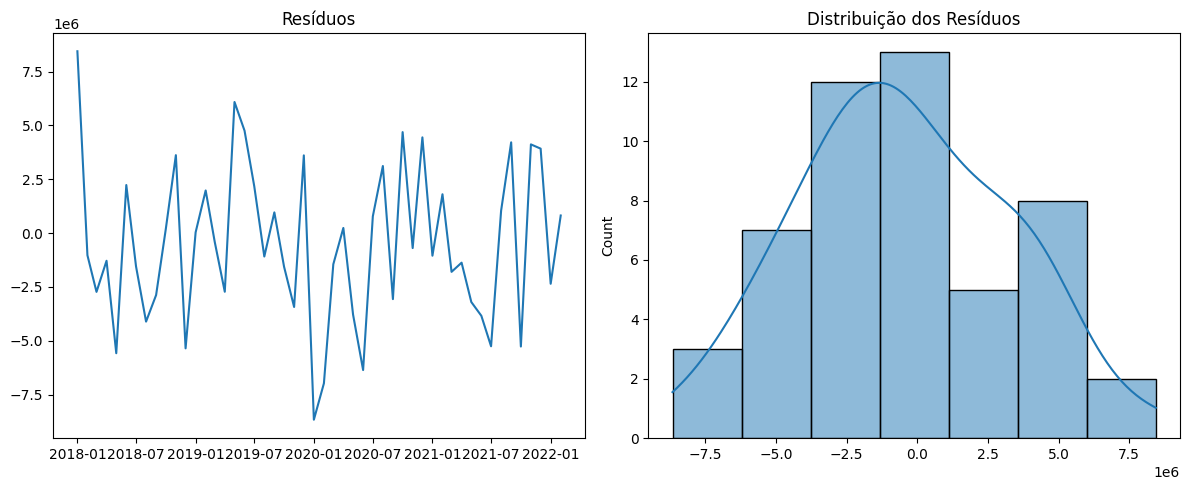

Shapiro-Wilk: p=0.9486 → Normal

Ljung-Box (autocorrelação dos resíduos):
      lb_stat  lb_pvalue
10  12.443646   0.256461

=== Segmento: DES_CATEGORIA_MATERIAL = anon_S30 ===

--- Testes de Estacionariedade ---
ADF: Estat=-4.1934, p=0.0007 → Estacionária
KPSS: Estat=0.2265, p=0.1000 → Estacionária


/var/folders/b7/j11xhgds7xj08061x1c3q5gm0000gn/T/ipykernel_8752/3981445790.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(serie, regression='c', nlags='auto')



--- Métricas de Avaliação ---
MAE:  121228.13
MASE: 0.686
wAPE: 22.49%
Bias: 37636.43


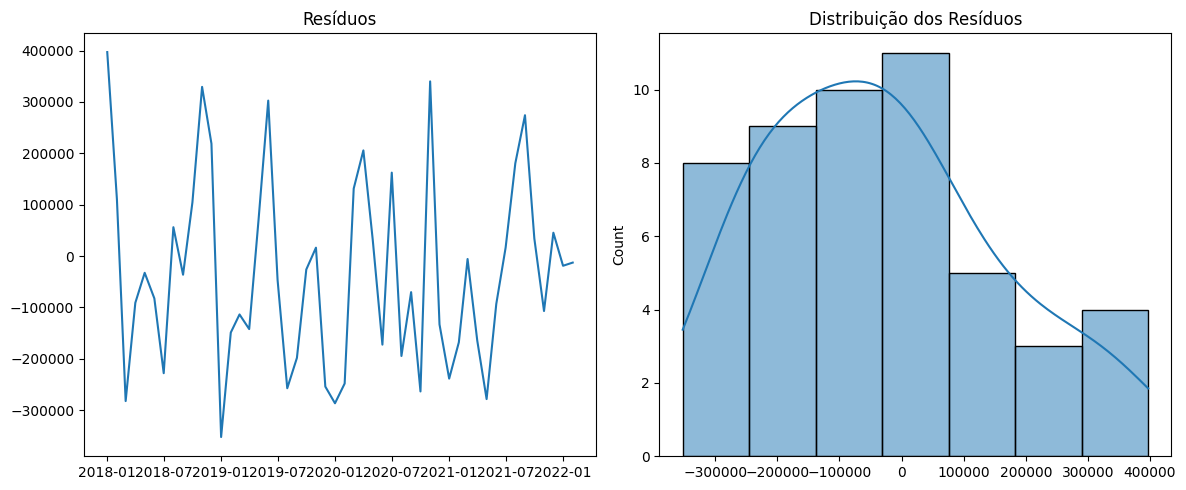

Shapiro-Wilk: p=0.1258 → Normal

Ljung-Box (autocorrelação dos resíduos):
      lb_stat  lb_pvalue
10  11.286981   0.335601

=== Segmento: DES_CATEGORIA_MATERIAL = anon_S11 ===

--- Testes de Estacionariedade ---
ADF: Estat=-6.7472, p=0.0000 → Estacionária
KPSS: Estat=0.1121, p=0.1000 → Estacionária


/var/folders/b7/j11xhgds7xj08061x1c3q5gm0000gn/T/ipykernel_8752/3981445790.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(serie, regression='c', nlags='auto')



--- Métricas de Avaliação ---
MAE:  2576231.42
MASE: 1.997
wAPE: 50.17%
Bias: -2576231.42


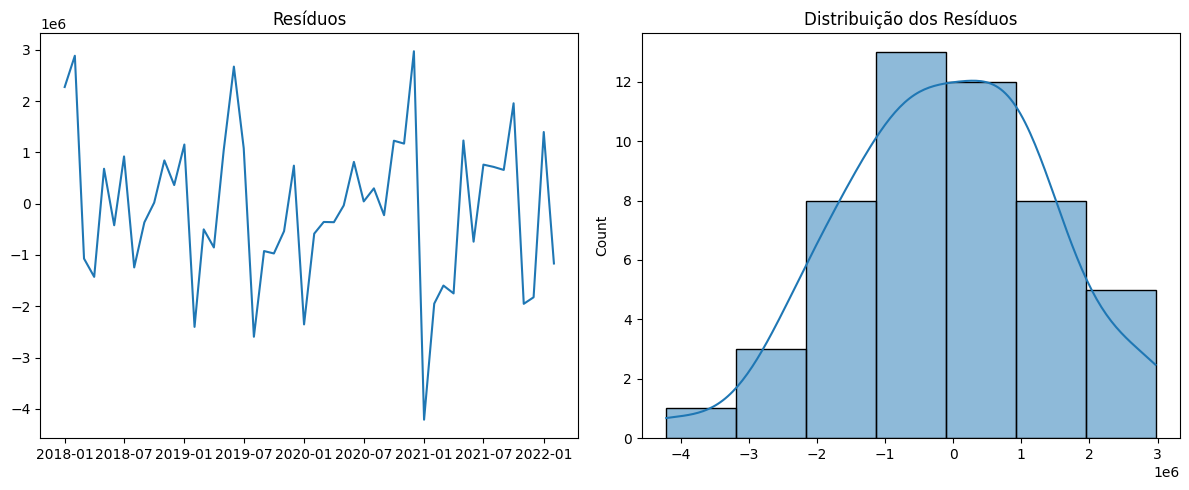

Shapiro-Wilk: p=0.7965 → Normal

Ljung-Box (autocorrelação dos resíduos):
     lb_stat  lb_pvalue
10  9.794447   0.458709

=== Segmento: DES_CATEGORIA_MATERIAL = anon_S18 ===

--- Testes de Estacionariedade ---
ADF: Estat=-8.2333, p=0.0000 → Estacionária
KPSS: Estat=0.0611, p=0.1000 → Estacionária


/var/folders/b7/j11xhgds7xj08061x1c3q5gm0000gn/T/ipykernel_8752/3981445790.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(serie, regression='c', nlags='auto')



--- Métricas de Avaliação ---
MAE:  305771.62
MASE: 0.751
wAPE: 28.49%
Bias: -305771.62


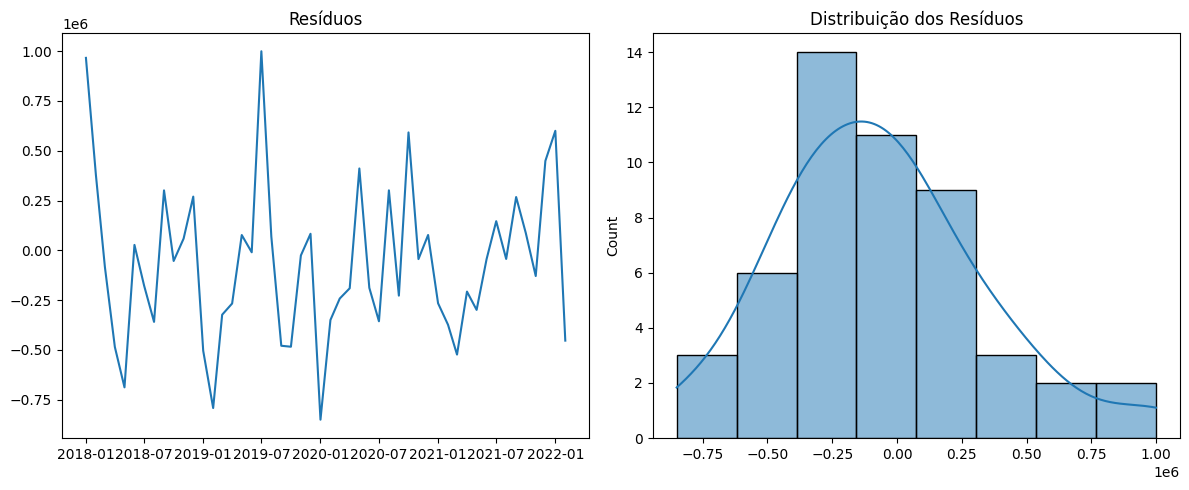

Shapiro-Wilk: p=0.2467 → Normal

Ljung-Box (autocorrelação dos resíduos):
      lb_stat  lb_pvalue
10  10.563245   0.392541


In [14]:
# Pipeline de execução

ROOT_DIR = Path.cwd().parent
load_processed_df = ROOT_DIR /"data"/"processed"/"processed_dataset.csv"

# caminho_dados = "dataset_tratado.csv"
df = load_processed_data(load_processed_df)
run_modeling_by_segment(df, 'COD_CANAL', order=(1,1,1), seasonal_order=(1,1,1,12))
run_modeling_by_segment(df, 'DES_CATEGORIA_MATERIAL', order=(1,1,1), seasonal_order=(1,1,1,12))